# 1. Install Dependencies

In [1]:
!pip -q install -U trackio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.5 MB/s eta 0:00:00


In [2]:
!pip -q install -U peft trackio


In [3]:
!pip -q install -U git+https://github.com/huggingface/trl.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip -q install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.2 MB/s eta 0:00:00


In [5]:
!pip -q install -U qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 15.6 MB/s eta 0:00:00


In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!rsync -a --info=progress2 "/content/drive/MyDrive/finetune-data/images/" "/content/images/"
!cp "/content/drive/MyDrive/finetune-data/train_structured.jsonl" "/content/train_structured.jsonl"
!cp "/content/drive/MyDrive/finetune-data/train_70.jsonl" "/content/train_70.jsonl"
!cp "/content/drive/MyDrive/finetune-data/val_30.jsonl"  "/content/val_30.jsonl"

     20,266,740 100%    3.76MB/s    0:00:05 (xfr#125, to-chk=0/126)


In [9]:
TRAIN_FILE = "/content/train_70.jsonl"
EVAL_FILE  = "/content/val_30.jsonl"
IMAGES_ROOT = "/content/images"

# 2. Load Dataset

In [10]:
from pathlib import Path
from datasets import load_dataset
from PIL import Image
import copy

DATA_ROOT = Path("/content/drive/MyDrive/finetune-data")
TRAIN_JSONL = DATA_ROOT / "/content/train_structured.jsonl"
VAL_JSONL   = DATA_ROOT / "val_30.jsonl"

raw = load_dataset(
    "json",
    data_files={"train": str(TRAIN_JSONL), "validation": str(VAL_JSONL)}
)

print(raw)
print("Raw keys:", raw["train"][0].keys())  # 'messages', 'meta'


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['messages', 'meta'],
        num_rows: 64
    })
    validation: Dataset({
        features: ['messages', 'meta'],
        num_rows: 20
    })
})
Raw keys: dict_keys(['messages', 'meta'])


In [11]:
system_message = """You are a Vision Language Model specialized in tropical disease recognition from clinical images.
Your task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it.
Keep the answer concise and medically grounded. Avoid adding unrelated information."""

In [12]:
from PIL import Image

def _extract_image_relpaths(example: dict):
    # Prioritize using meta.used_images (dataset already exists).
    meta = example.get("meta") or {}
    if isinstance(meta, dict) and meta.get("used_images"):
        return list(meta["used_images"])

    # Fallback: Scan messages for missing meta.used_images
    rels = []
    for m in example.get("messages", []):
        content = m.get("content")
        if isinstance(content, list):
            for c in content:
                if isinstance(c, dict) and c.get("type") == "image":
                    rels.append(c.get("image"))
    return rels



def resize_long_side(im: Image.Image, long_side: int = 512) -> Image.Image:
    w, h = im.size
    scale = long_side / max(w, h)
    if scale >= 1:
        return im
    return im.resize((int(w * scale), int(h * scale)), Image.BICUBIC)


def format_tropical_sample(example: dict, data_root: Path, long_side: int = 512):
    """
    Output:
      {
        "images": [PIL.Image, ...],
        "messages": [ {role, content[...]}, ... ],
        "meta": ...
      }
    """
    # Deep copy to avoid directly modifying the original data.
    messages = copy.deepcopy(example["messages"])
    meta = copy.deepcopy(example.get("meta"))

    # 1) Prepend system message
    system_msg = {
        "role": "system",
        "content": [{"type": "text", "text": system_message}],
    }
    messages = [system_msg] + messages

    # 2) Load the image as a PIL.Image file.
    relpaths = _extract_image_relpaths(example)
    images = []
    for rp in relpaths:
        if rp is None:
            continue
        rp = str(rp)
        abs_path = (data_root / rp) if not rp.startswith("/") else Path(rp)
        if not abs_path.exists():
            raise FileNotFoundError(f"Image not found: {abs_path}")
        img = Image.open(abs_path).convert("RGB")
        img = resize_long_side(img, long_side=long_side)
        images.append(img)



    # 3) Synchronization: replace "image": "<relpath>" in messages -> PIL.Image in the correct order
    img_i = 0
    for m in messages:
        content = m.get("content")
        if isinstance(content, list):
            for c in content:
                if isinstance(c, dict) and c.get("type") == "image":
                    if img_i < len(images):
                        c["image"] = images[img_i]
                        img_i += 1

    return {"images": images, "messages": messages, "meta": meta}


In [13]:
import copy
from PIL import Image as PILImage

def canonicalize_messages(sample: dict) -> dict:
    """
    - For content item type='image': keep only {'type':'image','image': <PIL or str/url>}
    - For content item type='text': keep only {'type':'text','text': <str>}
    - Remove all redundant keys (image=None, text=None, ...)
    - Keep the structure roles/system-user-assistant unchanged
    """
    s = copy.deepcopy(sample)

    new_messages = []
    for msg in s.get("messages", []):
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = []

        cleaned_content = []
        for c in content:
            if not isinstance(c, dict):
                continue

            ctype = c.get("type")

            if ctype == "image":
                img = c.get("image", None)
                # Valid if it is a PIL.Image or string path/url
                if isinstance(img, PILImage.Image) or isinstance(img, str):
                    cleaned_content.append({"type": "image", "image": img})
                else:
                    # image None -> remove this image block
                    continue

            elif ctype == "text":
                txt = c.get("text", None)
                if isinstance(txt, str) and txt.strip():
                    cleaned_content.append({"type": "text", "text": txt})
                else:
                    continue

            else:
                # Not text/image -> remove
                continue

        new_messages.append({"role": msg.get("role", "user"), "content": cleaned_content})

    s["messages"] = new_messages

    # Images list: Remove None if present.
    imgs = [im for im in s.get("images", []) if isinstance(im, PILImage.Image)]
    s["images"] = imgs

    return s


In [14]:
#1) Format: add system + load PIL images + change image path -> PIL
train_dataset = [format_tropical_sample(ex, DATA_ROOT, long_side=448) for ex in raw["train"]]
eval_dataset  = [format_tropical_sample(ex, DATA_ROOT, long_side=448) for ex in raw["validation"]]

# 2) Canonicalize: remove all None keys (text items should only contain {type,text}, image items should only contain {type,image})
train_dataset = [canonicalize_messages(s) for s in train_dataset]
eval_dataset  = [canonicalize_messages(s) for s in eval_dataset]

# 3) Sanity check
print(train_dataset[0].keys())                 # dict_keys(['images','messages','meta'])
print(type(train_dataset[0]["images"][0]))     # <class 'PIL.Image.Image'>
print(train_dataset[0]["messages"][0]["role"]) # system
print(train_dataset[0]["messages"][1]["role"]) # user


dict_keys(['images', 'messages', 'meta'])
<class 'PIL.Image.Image'>
system
user


In [15]:
s0 = canonicalize_messages(train_dataset[0])
print(s0)

{'images': [<PIL.Image.Image image mode=RGB size=448x441 at 0x7D8012905E20>, <PIL.Image.Image image mode=RGB size=448x266 at 0x7D8012905DC0>], 'messages': [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a Vision Language Model specialized in tropical disease recognition from clinical images.\nYour task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it.\nKeep the answer concise and medically grounded. Avoid adding unrelated information.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=448x441 at 0x7D8012905E20>}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=448x266 at 0x7D8012905DC0>}, {'type': 'text', 'text': 'Clinical case 01.\nSymptoms: 20-year-old woman from Sudan/Uganda presenting with fever, severe asthenia, chest and abdominal pain, nausea, vomiting, diarrhoea, gum bleeding, and shock.\nTask: Using the image(s) and symptoms, pro

In [16]:
train_dataset[0]

{'images': [<PIL.Image.Image image mode=RGB size=448x441>,
  <PIL.Image.Image image mode=RGB size=448x266>],
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in tropical disease recognition from clinical images.\nYour task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it.\nKeep the answer concise and medically grounded. Avoid adding unrelated information.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=448x441>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=448x266>},
    {'type': 'text',
     'text': 'Clinical case 01.\nSymptoms: 20-year-old woman from Sudan/Uganda presenting with fever, severe asthenia, chest and abdominal pain, nausea, vomiting, diarrhoea, gum bleeding, and shock.\nTask: Using the image(s) and symptoms, provide the most likely diagnosis and how

In [17]:
eval_dataset[0]

{'images': [<PIL.Image.Image image mode=RGB size=448x217>],
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in tropical disease recognition from clinical images.\nYour task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it.\nKeep the answer concise and medically grounded. Avoid adding unrelated information.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=448x217>},
    {'type': 'text',
     'text': 'Clinical case 68.\nSymptoms: Young Malawian woman with generalized rash involving skin and mucous membranes, skin sloughing, following nevirapine use.\nTask: Using the image(s) and symptoms, provide the most likely diagnosis and how to confirm it.'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Symptoms: Young Malawian woman with generalized rash involving skin and

# 3. Load Model & Check Performance

In [18]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-2B-Instruct"

In [19]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [20]:
train_dataset[0]

{'images': [<PIL.Image.Image image mode=RGB size=448x441>,
  <PIL.Image.Image image mode=RGB size=448x266>],
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a Vision Language Model specialized in tropical disease recognition from clinical images.\nYour task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it.\nKeep the answer concise and medically grounded. Avoid adding unrelated information.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=448x441>},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=448x266>},
    {'type': 'text',
     'text': 'Clinical case 01.\nSymptoms: 20-year-old woman from Sudan/Uganda presenting with fever, severe asthenia, chest and abdominal pain, nausea, vomiting, diarrhoea, gum bleeding, and shock.\nTask: Using the image(s) and symptoms, provide the most likely diagnosis and how

In [21]:
train_dataset[0]['messages'][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=448x441>},
   {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=448x266>},
   {'type': 'text',
    'text': 'Clinical case 01.\nSymptoms: 20-year-old woman from Sudan/Uganda presenting with fever, severe asthenia, chest and abdominal pain, nausea, vomiting, diarrhoea, gum bleeding, and shock.\nTask: Using the image(s) and symptoms, provide the most likely diagnosis and how to confirm it.'}]}]

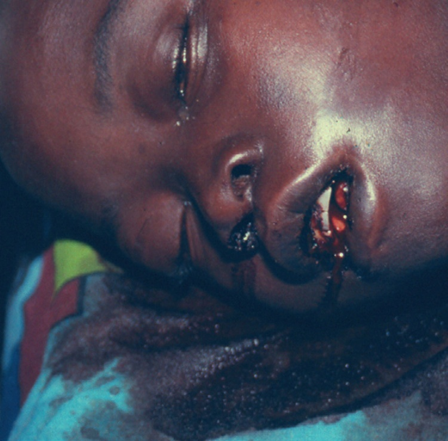

In [22]:
train_dataset[0]['images'][0]

In [23]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['messages'][1:2],  # Use the sample with has only user message
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample['messages'])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [24]:
output = generate_text_from_sample(model, processor, train_dataset[0])
print(output)


The image shows a patient with symptoms of severe asthenia, chest and abdominal pain, nausea, vomiting, diarrhoea, gum bleeding, and shock. These symptoms are consistent with the diagnosis of severe malaria. To confirm the diagnosis, the following steps can be taken:

1. **Laboratory Tests:**
   - **Blood Tests:** Perform a complete blood count (CBC) to assess the number of red blood cells, white blood cells, and platelets. A high white blood cell count with a high percentage of immature forms (such as lymphocytes) and a low hemoglobin level is indicative of severe malaria.
   - **Serum Tests:** Measure the levels of malaria parasites in the blood using a rapid diagnostic test (RDT) or a more sensitive PCR test. A positive RDT or PCR test confirms the diagnosis of malaria.

2. **Clinical Examination:**
   - **Physical Examination:** Observe for signs of severe malaria, such as fever, tachycardia, and jaundice. Look for signs of organ damage, such as jaundice, hepatomegaly, and splenome

**Remove model and Clean GPU**

Before proceed with training the model in the next section, clear the current variables and clean the GPU to free up resources.

In [25]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 4.12 GB


# 4. Fine-Tune the Model using TRL

## 4.1 Load the Quantized Model for Training

In [26]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## 4.2 Set Up QLoRA and SFTConfig

In [27]:
from peft import LoraConfig

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

Using Supervised Fine-Tuning (SFT) to refine the model’s performance on the task at hand. To do this, we’ll define the training arguments using the SFTConfig class from the TRL library. SFT allows us to provide labeled data, helping the model learn to generate more accurate responses based on the input it receives. This approach ensures that the model is tailored to our specific use case, leading to better performance in understanding and responding to visual queries.

In [28]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-tropical-disease-train-structure-epoch-3",  # Directory to save the model
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=1,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=4,  # Steps to accumulate gradients
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    max_length=None,
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    # Logging and evaluation
    logging_steps=1,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="trackio",  # Reporting tool for tracking metrics
)

## 4.3 Training the Model

In [29]:
import trackio
trackio.init(
    project="qwen2-tropical-disease-train-structure-epoch-3",
    #name="run1",
    config=training_args.to_dict() if hasattr(training_args, "to_dict") else {},
    space_id="BaoNgoc29/finetune-model",
    #dataset_id="BaoNgoc29/finetune-model-dataset",
)


* Trackio project initialized: qwen2-tropical-disease-train-structure-epoch-3
* Trackio metrics will be synced to Hugging Face Dataset: BaoNgoc29/finetune-model-dataset
* Found existing space: https://huggingface.co/spaces/BaoNgoc29/finetune-model
* View dashboard by going to: https://BaoNgoc29-finetune-model.hf.space/


* GPU detected, enabling automatic GPU metrics logging
* Created new run: BaoNgoc29-1769658399


In [30]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    processing_class=processor,
)

In [31]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: BaoNgoc29/trackio-dataset
* Found existing space: https://huggingface.co/spaces/BaoNgoc29/trackio
* View dashboard by going to: https://BaoNgoc29-trackio.hf.space/


* GPU detected, enabling automatic GPU metrics logging
* Created new run: BaoNgoc29-1769658408


Step,Training Loss,Validation Loss
10,11.543600,13.276500
20,9.874500,10.029037
30,8.416400,8.166788
40,8.435100,7.653436


Exception in thread Thread-20 (_init_client_background):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/httpx/_transports/default.py", line 101, in map_httpcore_exceptions
    yield
  File "/usr/local/lib/python3.12/dist-packages/httpx/_transports/default.py", line 250, in handle_request
    resp = self._pool.handle_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/httpcore/_sync/connection_pool.py", line 256, in handle_request
    raise exc from None
  File "/usr/local/lib/python3.12/dist-packages/httpcore/_sync/connection_pool.py", line 236, in handle_request
    response = connection.handle_request(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/httpcore/_sync/connection.py", line 103, in handle_request
    return self._connection.handle_request(request)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/

* Run finished. Uploading logs to Trackio (please wait...)


TrainOutput(global_step=48, training_loss=9.9934790233771, metrics={'train_runtime': 853.0073, 'train_samples_per_second': 0.225, 'train_steps_per_second': 0.056, 'total_flos': 1271473667251200.0, 'train_loss': 9.9934790233771})

In [32]:
trainer.save_model(training_args.output_dir)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...epoch-3/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...adapter_model.safetensors: 100%|##########| 2.20MB / 2.20MB            

  ...re-epoch-3/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

# 5. Testing the Fine-Tuned Model

In [33]:
import os
from pathlib import Path

ROOT = Path("/content")

candidates = []
for p in ROOT.rglob("adapter_model.safetensors"):
    candidates.append(str(p.parent))

print("Found adapter folders:")
for c in sorted(set(candidates)):
    print("-", c)


Found adapter folders:
- /content/qwen2-tropical-disease-train-structure-epoch-3
- /content/qwen2-tropical-disease-train-structure-epoch-3/checkpoint-20
- /content/qwen2-tropical-disease-train-structure-epoch-3/checkpoint-40
- /content/qwen2-tropical-disease-train-structure-epoch-3/checkpoint-48


In [34]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 4.12 GB


In [35]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from peft import PeftModel

model_id = "Qwen/Qwen2-VL-2B-Instruct"
adapter_path = "qwen2-tropical-disease-train-structure-epoch-3"

processor = Qwen2VLProcessor.from_pretrained(model_id)

base = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.float16,
)

model = PeftModel.from_pretrained(base, adapter_path)
model.eval()
model.config.use_cache = False
if hasattr(model, "generation_config"):
    model.generation_config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
import re
import gc
import unicodedata
from pathlib import Path
from typing import List, Optional, Dict, Any

import torch
from PIL import Image as PILImage

# ----------------------------
# CONFIG
# ----------------------------
TEST_DATA_ROOT = Path("/content/drive/MyDrive/Test-Data/extracted-data")
MAX_CASES = None

# avoid OOM
MAX_IMAGES = 4
MAX_IMAGE_SIDE = 448    # Reduce VRAM
MAX_NEW_TOKENS = 192
TEMPERATURE = 0.0

system_message = """You are a Vision Language Model specialized in tropical disease recognition from clinical images.
Your task is to analyze the provided clinical images and symptoms, then provide the most likely diagnosis and how to confirm it. Answer in ENGLISH ONLY.
Keep the answer concise and medically grounded. Avoid adding unrelated information."""

OUTPUT_FORMAT_INSTRUCTION = (
    "Reply strictly in this format:\n"
    "Diagnosis: <one most likely diagnosis>\n"
    "Reason: <one short explanation based on the image and symptoms>\n"
)

# ----------------------------
# IMAGE HELPERS
# ----------------------------
def find_case_images(case_dir: Path) -> List[Path]:
    exts = {".jpg", ".jpeg", ".png", ".webp"}
    files: List[Path] = []

    #for ext in exts:
        #files += list(case_dir.glob(f"*{ext}"))
        #files += list(case_dir.glob(f"*{ext.upper()}"))

    images_dir = case_dir / "images"
    if images_dir.exists():
        for ext in exts:
            files += list(images_dir.glob(f"*{ext}"))
            files += list(images_dir.glob(f"*{ext.upper()}"))

    # sort + unique
    return sorted(set(files))

def load_pil_images(paths: List[Path], max_images: int = MAX_IMAGES, max_side: int = MAX_IMAGE_SIDE) -> List[PILImage.Image]:
    out: List[PILImage.Image] = []
    for p in paths[:max_images]:
        try:
            img = PILImage.open(str(p)).convert("RGB")
            img.thumbnail((max_side, max_side))
            out.append(img)
        except Exception as e:
            print(f"[WARN] Failed to load image {p}: {e}")
    return out

# ----------------------------
# INFERENCE (correct prompt training)
# ----------------------------
@torch.inference_mode()

def has_non_latin(s: str) -> bool:
    for ch in s:
        if ch.isalpha():
            name = unicodedata.name(ch, "")
            if "LATIN" not in name:
                return True
    return False

def run_qwen2_case(
    user_prompt: str,
    images: Optional[List[PILImage.Image]] = None,
    max_new_tokens: int = MAX_NEW_TOKENS,
) -> Dict[str, Any]:

    prompt_text = user_prompt.strip()
    if OUTPUT_FORMAT_INSTRUCTION not in prompt_text:
        prompt_text = prompt_text + "\n\n" + OUTPUT_FORMAT_INSTRUCTION

    def _generate_once(extra_rule: str = "") -> str:
        # Build message content
        user_content = []
        if images:
            for img in images:
                user_content.append({"type": "image", "image": img})
        user_content.append({"type": "text", "text": extra_rule + prompt_text})

        messages = [
            {"role": "system", "content": [{"type": "text", "text": system_message}]},
            {"role": "user", "content": user_content},
        ]

        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        device = next(model.parameters()).device

        inputs = processor(
            text=[text],
            images=images if images else None,
            padding=True,
            truncation=False,
            return_tensors="pt",
        ).to(device)

        gen_kwargs = dict(
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

        with torch.autocast(device_type="cuda", dtype=torch.float16):
            gen_ids = model.generate(**inputs, **gen_kwargs)

        trimmed = [out[len(inp):] for inp, out in zip(inputs.input_ids, gen_ids)]
        answer = processor.batch_decode(
            trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0]

        # cleanup VRAM
        del inputs, gen_ids, trimmed
        torch.cuda.empty_cache()
        gc.collect()

        return answer

    # 1) generate 1st time
    answer = _generate_once()

    # 2) If a non-Latin word is involved, regenerate it with stronger rule
    if has_non_latin(answer):
        strong_rule = (
            "IMPORTANT: Output ENGLISH ONLY using Latin characters. "
            "Do NOT output any Chinese/Japanese/Korean/Vietnamese characters. "
            "Rewrite fully in English.\n\n"
        )
        answer = _generate_once(extra_rule=strong_rule)

    # 3) Take the Diagnosis/Reason lines
    lines = [ln.strip() for ln in answer.splitlines() if ln.strip()]
    diag = next((ln for ln in lines if ln.lower().startswith("diagnosis:")), None)
    reason = next((ln for ln in lines if ln.lower().startswith("reason:")), None)
    if diag or reason:
        answer = "\n".join([x for x in [diag, reason] if x])

    return {"answer": answer, "input_prompt": user_prompt}


# ----------------------------
# LOOP ALL CASES
# ----------------------------
def run_diagnosis_testcase(max_cases: int | None = MAX_CASES):
    if not TEST_DATA_ROOT.exists():
        raise FileNotFoundError(f"Test data directory not found: {TEST_DATA_ROOT}")

    results = []
    case_counter = 0

    print(f"Scanning for cases in: {TEST_DATA_ROOT}")

    for case_dir in sorted(TEST_DATA_ROOT.iterdir()):
        if max_cases is not None and case_counter >= max_cases:
            break
        if not case_dir.is_dir():
            continue

        query_path = case_dir / "query.txt"
        gt_path = case_dir / "ground_truth.txt"
        if not query_path.exists() or not gt_path.exists():
            continue

        # Load data
        user_prompt = query_path.read_text(encoding="utf-8", errors="ignore").strip()
        ground_truth = gt_path.read_text(encoding="utf-8", errors="ignore").strip()

        # Find and Load image
        img_paths = find_case_images(case_dir)
        pil_images = load_pil_images(img_paths)
        image_paths_str = [str(p) for p in img_paths]

        print("\n" + "=" * 80)
        print(f"CASE {case_counter + 1}: {case_dir.name}")
        print(f"Images found: {len(img_paths)} | using: {len(pil_images)}")
        print("=" * 80)

        out = run_qwen2_case(user_prompt=user_prompt, images=pil_images)

        results.append({
            "case_id": case_dir.name,
            "input_prompt": user_prompt,
            "input_image": ", ".join(image_paths_str),
            "ground_truth": ground_truth,
            "answer": out["answer"],
        })

        case_counter += 1

    print(f"\nProcessed {case_counter} cases.")
    return results


## Testing 33 cases

In [37]:
# Testing 33 cases
results = run_diagnosis_testcase()


Scanning for cases in: /content/drive/MyDrive/Test-Data/extracted-data


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



CASE 1: 001
Images found: 0 | using: 0

CASE 2: 002
Images found: 1 | using: 1

CASE 3: 003
Images found: 0 | using: 0

CASE 4: 004
Images found: 3 | using: 3

CASE 5: 005
Images found: 0 | using: 0

CASE 6: 006
Images found: 0 | using: 0

CASE 7: 007
Images found: 3 | using: 3

CASE 8: 008
Images found: 3 | using: 3

CASE 9: 009
Images found: 0 | using: 0

CASE 10: 010
Images found: 2 | using: 2

CASE 11: 011
Images found: 0 | using: 0

CASE 12: 012
Images found: 1 | using: 1

CASE 13: 013
Images found: 1 | using: 1

CASE 14: 014
Images found: 1 | using: 1

CASE 15: 015
Images found: 4 | using: 4

CASE 16: 016
Images found: 0 | using: 0

CASE 17: 017
Images found: 0 | using: 0

CASE 18: 018
Images found: 2 | using: 2

CASE 19: 019
Images found: 1 | using: 1

CASE 20: 020
Images found: 4 | using: 4

CASE 21: 021
Images found: 0 | using: 0

CASE 22: 022
Images found: 0 | using: 0

CASE 23: 023
Images found: 0 | using: 0

CASE 24: 024
Images found: 0 | using: 0

CASE 25: 025
Images foun

In [38]:
import pandas as pd
out_path = "/content/result_testing-epoch-3-train-structure.xlsx"
pd.DataFrame(results).to_excel(out_path, index=False)
print("Saved:", out_path)


Saved: /content/result_testing-epoch-3-train-structure.xlsx


## Demo testing 2 cases

In [39]:
demo_results = run_diagnosis_testcase(max_cases=2)

Scanning for cases in: /content/drive/MyDrive/Test-Data/extracted-data

CASE 1: 001
Images found: 0 | using: 0

CASE 2: 002
Images found: 1 | using: 1

Processed 2 cases.


In [40]:
import pandas as pd

out_path = "/content/result_testing-3-cases.xlsx"
df_demo = pd.DataFrame(
    demo_results,
    columns=["case_id", "input_prompt", "input_image", "ground_truth", "answer"]
)
df_demo.to_excel(out_path, index=False)

print("Saved:", out_path, "| rows:", len(df_demo))
df_demo.head(3)

Saved: /content/result_testing-3-cases.xlsx | rows: 2


,case_id,input_prompt,input_image,ground_truth,answer
0,001,"A 53-year-old woman presented with fever, coug...",,The diagnosis is enteric fever caused by Salmo...,Diagnosis: Malaria\nReason: The patient presen...
1,002,A 26-year-old woman presents one week after re...,/content/drive/MyDrive/Test-Data/extracted-dat...,"The diagnosis is malaria, caused by a Plasmodi...",Diagnosis: Malaria\nReason: The patient's symp...
